In [1]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

In [2]:
class jrp:
    def __init__(self):
        self.gamma = 0.9
        self.cred = 10.0
        self.move_rew = -2.0
        self.max_move = 5
        self.max_car = 20

In [3]:
class Poisson:
    def __init__(self, exp, e):
        self.lamda =  exp
        self._pmf = []
        self.e = e
        
        i=0
        s=0
        while poisson.pmf(i,exp) < e:
            i += 1
        
        self.alpha = i

        while poisson.pmf(i,exp) >= e:
            self._pmf += [poisson.pmf(i,exp)]
            s += self._pmf[-1]
            i += 1
        
        self.beta = i

        self._pmf = np.array(self._pmf)/s
    
    def pmf(self, x):
        return self._pmf[self.alpha+x]

In [4]:
class Location:
    def __init__(self, exp_req, exp_ret):
        e = 0.01
        
        self.exp_req = exp_req
        self.exp_ret = exp_ret
        self.preq = Poisson(exp_req, e)
        self.pret = Poisson(exp_ret, e)

In [5]:
# Policy Iteration Algo

# Initialization
env = jrp()
loc1 = Location(4,2)
loc2 = Location(3,3)

v = np.zeros((env.max_car+1,env.max_car+1))
pi = np.zeros((env.max_car+1,env.max_car+1), dtype = np.int8)

def exp_rew(state, action, v):
    new_state = (state[0]-action, state[1]+action)
    if new_state[0] < 0 or new_state[1] < 0:
        raise Exception("invalid action: {} for state: ({},{})".format(action, state[0], state[1]))

    rew = env.move_rew * abs(action)

    for req1 in range(loc1.preq.alpha, loc1.preq.beta):
        for ret1 in range(loc1.pret.alpha, loc1.pret.beta):
            for req2 in range(loc2.preq.alpha, loc2.preq.beta):
                for ret2 in range(loc2.pret.alpha, loc2.pret.beta):
                    p = loc1.preq.pmf(req1)*loc1.pret.pmf(ret1)*loc2.preq.pmf(req2)*loc2.pret.pmf(ret2)
                    r = (min(req1, new_state[0]) + min(req2, new_state[1]))*env.cred
                    s = (min(max(0, new_state[0]-req1) + ret1, env.max_car), min(max(0, new_state[1]-req2) + ret2, env.max_car))

                    rew += p*(r + env.gamma*v[s[0]][s[1]])
    
    return rew

In [6]:
iter_count = 5
i = 1
theta = 500

v_list = []
pi_list = [pi]

while i <= iter_count:
    print("\nIteration {}\n".format(i))
    i += 1

    # Policy Evaluation

    v_old = np.empty_like(v)
    theta /= 10
    while True:
        delta = 0.0

        np.copyto(v_old, v)
        for c1 in range(0, env.max_car + 1):
            for c2 in range(0, env.max_car + 1):
                v[c1][c2] = exp_rew((c1,c2), pi[c1][c2], v_old)
                delta = max(delta, abs(v[c1][c2]-v_old[c1][c2]))

        print("delta: {}, theta: {}".format(delta, theta))

        if delta < theta:
            break
    
    v_list += [v.copy()]
    
    # Policy Improvement

    for c1 in range(0, env.max_car + 1):
        for c2 in range(0, env.max_car + 1):
            state = (c1,c2)
            max_action = 0
            max_rew = 0.0
            actions = range(-min(env.max_move,state[1]), 1+min(env.max_move,state[0]))

            for action in actions:
                rew = exp_rew(state, action, v)
                if rew > max_rew:
                    max_action = action
                    max_rew = rew
            
            pi[c1][c2] = max_action
    
    pi_list += [pi.copy()]


Iteration 1

delta: 68.81048361558193, theta: 50.0
delta: 61.92943525402326, theta: 50.0
delta: 55.73011173864518, theta: 50.0
delta: 50.02080034476339, theta: 50.0
delta: 44.46541334692364, theta: 50.0

Iteration 2

delta: 66.1576732039644, theta: 5.0
delta: 50.37667036156142, theta: 5.0
delta: 32.332177396587724, theta: 5.0
delta: 26.86357411583367, theta: 5.0
delta: 23.846841230486007, theta: 5.0
delta: 21.093185086470896, theta: 5.0
delta: 18.612130759129457, theta: 5.0
delta: 16.40201630988838, theta: 5.0
delta: 14.45103659923359, theta: 5.0
delta: 12.740248922368949, theta: 5.0
delta: 11.24635659088392, theta: 5.0
delta: 9.944367343230397, theta: 5.0
delta: 8.80971749421019, theta: 5.0
delta: 7.819637759925854, theta: 5.0
delta: 6.9538325811565755, theta: 5.0
delta: 6.194670794561603, theta: 5.0
delta: 5.527082903047585, theta: 5.0
delta: 4.938310462114146, theta: 5.0

Iteration 3

delta: 6.527965709683144, theta: 0.5
delta: 5.221624936093917, theta: 0.5
delta: 4.507137981671804

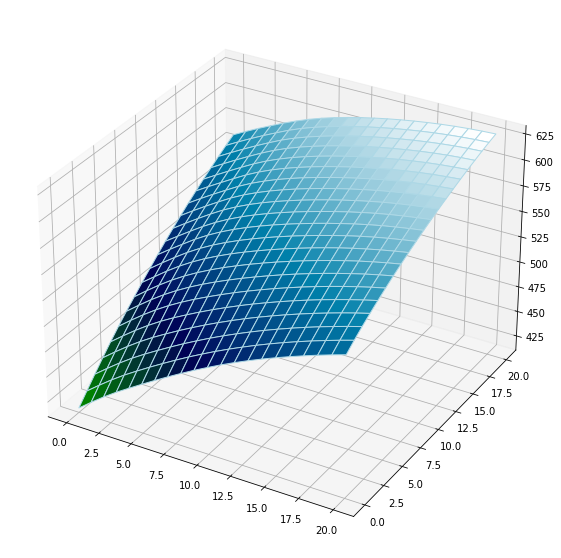

414.8868925353015

In [38]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection = '3d')

x = np.array(range(env.max_car+1))
y = np.array(range(env.max_car+1))
X, Y = np.meshgrid(x, y)
Z = v_list[-1]

ax.plot_surface(X,Y,Z, cmap = 'ocean', edgecolor = 'lightblue')

plt.show()
v_list[-1][0][0]

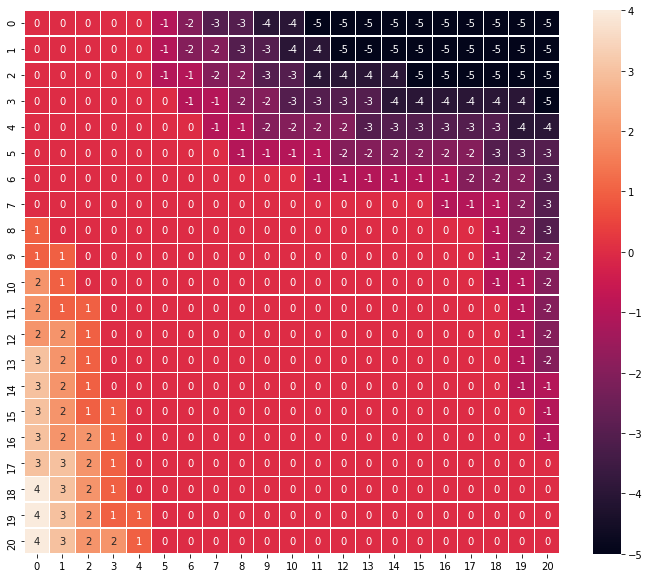

In [42]:
fig = plt.figure(figsize=(12,10))
sns.heatmap(pi_list[-1], linewidths=0.2, annot=True)
plt.show()